In [235]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import re
import scipy

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [236]:
stop = stopwords.words('english')

# **Import Clean and Format Data**

Read CSV file, remove unwanted comma characters within the review strings. Reconstruct CSV line; write to new CSV file.

In [237]:
colNames = ""
newLines = []


with open('/content/deception_data_converted_final.csv') as f:
    lines = f.readlines()
    newLines.append(lines[0])
    for line in range(1,len(lines)):
      
      
      x = lines[line].split(',')
      #print("|")
      #print(x[2:len(x)])
      review = ""
      for n in range(2,len(x)):
        x[n].replace(',','')
        review += x[n]
      
      y=x[0]+ ','+x[1] + ',' + review
      #print(y)
      #print("|")
      newLines.append(y)
      f.close()
      



In [238]:
with open(r'/content/deception_data_converted_clean.csv', 'w') as fp:
    for item in newLines:
        # write each item on a new line
        fp.write("%s\n" % item)
    print('Done')

Done


# **Instantiate New Dataframe from Clean Data**

In [239]:
df = pd.read_csv('/content/deception_data_converted_clean.csv')

In [240]:
df.head()

,lie,sentiment,review
0,f,n,'Mike\'s Pizza High Point NY Service was very ...
1,f,n,'i really like this buffet restaurant in Marsh...
2,f,n,'After I went shopping with some of my friend ...
3,f,n,'Olive Oil Garden was very disappointing. I ex...
4,f,n,'The Seven Heaven restaurant was never known f...


# **Additional Data Cleaning**


*   Remove all columns size of word is 2 or less

*   Remove all columns that contain words that either are number or contain numbers
*   Remove columns that contain words that are larger than 13 characters




In [241]:
def has_numbers(inputString):
    return any(char.isdigit() for char in inputString)

def colCleaning(df):

  remList = []
  for col in df.columns:
    if has_numbers(col):
      remList.append(col)
    elif len(col) < 2:
      if col not in remList:
        remList.append(col)
    elif len(col) > 13:
      if col not in remList:
        remList.append(col)
  return remList


# **Separate the Data By labels**

In [242]:
dfSent = df[['sentiment', 'review']]
dfLie = df[['lie', 'review']]

# **Naive Bayes**

Import required dependencies

In [243]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
)
from sklearn.model_selection import train_test_split

import numpy as np
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer

# **Sentiment**

Removal of Stop Words

In [244]:
dfSent['review'] = dfSent['review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

<ipython-input-244-bc35a5e871f6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfSent['review'] = dfSent['review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))


Change Data type of labels to category

In [245]:
dfSent['sentiment'] = dfSent['sentiment'].astype("category")
dfLie['lie'] = dfLie['lie'].astype("category")
dfSent.dtypes

<ipython-input-245-cb8035405524>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfSent['sentiment'] = dfSent['sentiment'].astype("category")
<ipython-input-245-cb8035405524>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfLie['lie'] = dfLie['lie'].astype("category")


sentiment    category
review         object
dtype: object

Create the test train split (80/20), count vectorize, store labels seperately

In [246]:
vectorizer = TfidfVectorizer(stop_words=stop)
reviewsArr = vectorizer.fit_transform(dfSent['review'].tolist())
bow = np.array(reviewsArr.todense())

colnames = vectorizer.get_feature_names_out()

revDf = pd.DataFrame(reviewsArr.toarray(), columns=colnames)
removeList = colCleaning(revDf)
revDf = revDf.drop(columns=removeList)

x = scipy.sparse.csr_matrix(revDf.values)
labels = dfSent['sentiment']

In [247]:
X_train, X_test, y_train, y_test = train_test_split(x, labels, 
                                                    test_size=0.2)

Check Data Types

In [248]:
labels.cat.categories


Index(['n', 'p'], dtype='object')

Fit the Model

In [249]:
modelSent = MultinomialNB().fit(X_train, y_train)
y_pred = modelSent.predict(X_test)


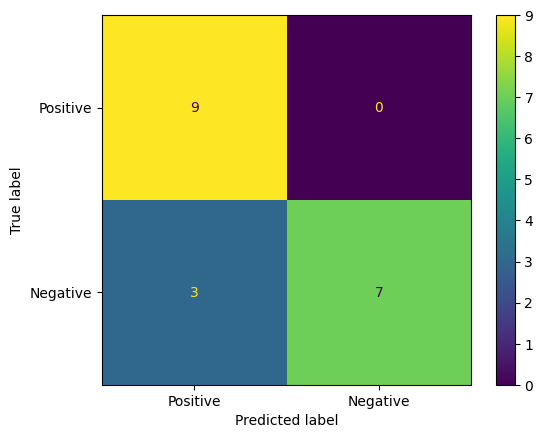

In [250]:
cmlables = ["Positive", "Negative"]
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cmlables)
disp.plot();

In [251]:
print('Accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8421052631578947
              precision    recall  f1-score   support

           n       0.75      1.00      0.86         9
           p       1.00      0.70      0.82        10

    accuracy                           0.84        19
   macro avg       0.88      0.85      0.84        19
weighted avg       0.88      0.84      0.84        19



# **Lie Detection**

Removal of Stop Words provided a higher accuracy that leaving in place

In [252]:
dfLie['review'] = dfLie['review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

<ipython-input-252-56947d643af4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfLie['review'] = dfLie['review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))


Create the test train split (80/20), count vectorize, store labels seperately

In [253]:
vectorizer = TfidfVectorizer(stop_words=stop)
reviewsArr = vectorizer.fit_transform(dfLie['review'].tolist())
bow = np.array(reviewsArr.todense())

colnames = vectorizer.get_feature_names_out()

revDf = pd.DataFrame(reviewsArr.toarray(), columns=colnames)
removeList = colCleaning(revDf)
revDf = revDf.drop(columns=removeList)

x = scipy.sparse.csr_matrix(revDf.values)
labels = dfSent['sentiment']
labels = dfLie['lie']

In [254]:
X_train, X_test, y_train, y_test = train_test_split(x, labels, 
                                                    test_size=0.2)

Check Data Types

In [255]:
labels.cat.categories

Index(['f', 't'], dtype='object')

Fit the model

In [256]:
modelLie = MultinomialNB().fit(X_train, y_train)
y_pred = modelLie.predict(X_test)


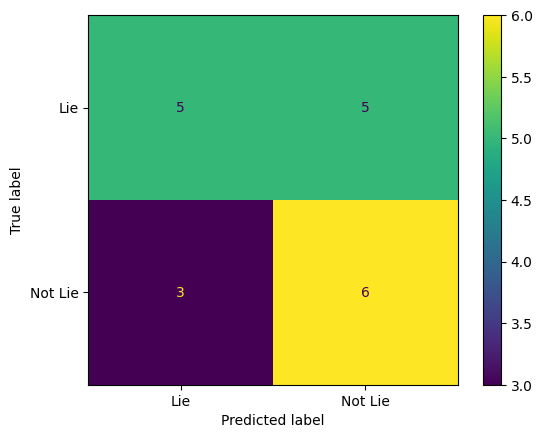

In [259]:
cmlables = ["Lie", "Not Lie"]
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cmlables)
disp.plot();

In [260]:
print('Accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.5789473684210527
              precision    recall  f1-score   support

           f       0.62      0.50      0.56        10
           t       0.55      0.67      0.60         9

    accuracy                           0.58        19
   macro avg       0.59      0.58      0.58        19
weighted avg       0.59      0.58      0.58        19

